In [1]:
# # Mounting drive for running the code through Google colab 
# from google.colab import drive
# drive.mount('/content/drive')

**The Python version we use: 3.7.13**

# 1- Tokenizer

In [2]:
# # We won't need TensorFlow here
# !pip uninstall -y tensorflow

# # Install `transformers` from master
# # Install huggingface-hub-0.8.1 pyyaml-6.0 tokenizers-0.12.1 transformers-4.22.0.dev0
# !pip install git+https://github.com/huggingface/transformers
# !pip list | grep -E 'transformers|tokenizers'

In [3]:
from tokenizers import SentencePieceBPETokenizer

tokenizer = SentencePieceBPETokenizer()

In [4]:
paths = '/kaggle/input/ecgbert/ecg_train.csv' ###path to the train_dataset
special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<cls>", "<sep>", "<mask>"]

In [5]:
tokenizer.train(
    paths,
    vocab_size=52_000,
    min_frequency=2, #The minimum frequency a pair should have in order to be merged.
    show_progress=True,
    limit_alphabet=100, #The maximum different characters to keep in the alphabet.
    special_tokens=special_tokens
)
print("voc size", tokenizer.get_vocab_size())




voc size 52000


# Making Our Tokenizer 

In [6]:
address = "tokenizer_pretrained" #Replace your local address here

In [7]:
import transformers
tokenizer = transformers.PreTrainedTokenizerFast(tokenizer_object=tokenizer, special_tokens=special_tokens) 

In [8]:
tokenizer.bos_token = "<s>"
tokenizer.bos_token_id = tokenizer.convert_tokens_to_ids("<s>")
tokenizer.pad_token = "<pad>"
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids("<pad>")
tokenizer.eos_token = "</s>"
tokenizer.eos_token_id = tokenizer.convert_tokens_to_ids("</s>")
tokenizer.unk_token = "<unk>"
tokenizer.unk_token_id = tokenizer.convert_tokens_to_ids("<unk>")
tokenizer.cls_token = "<cls>"
tokenizer.cls_token_id = tokenizer.convert_tokens_to_ids("<cls>")
tokenizer.sep_token = "<sep>"
tokenizer.sep_token_id = tokenizer.convert_tokens_to_ids("<sep>")
tokenizer.mask_token = "<mask>"
tokenizer.mask_token_id = tokenizer.convert_tokens_to_ids("<mask>")

In [9]:
#!mkdir HeartBert
tokenizer.save_pretrained(address)

('tokenizer_pretrained/tokenizer_config.json',
 'tokenizer_pretrained/special_tokens_map.json',
 'tokenizer_pretrained/tokenizer.json')

# 2- Heart MLM Model 

# HeartBert---training phase

In [10]:
# # Check that we have a GPU (for colab)
# !nvidia-smi

In [11]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

True

# 2-1-  Model Config 


In [12]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

# 2-2- Tokenizer

In [13]:
from transformers import AutoTokenizer

address = '/kaggle/working/tokenizer_pretrained'
tokenizer = AutoTokenizer.from_pretrained(address) 

# 2-3- MLM definition 

In [14]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print(model.num_parameters())

2025-05-26 13:30:06.681536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748266206.889953      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748266206.949836      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


83504416


# 2-4- Dataset Generation

In [15]:
from torch.utils.data import Dataset
import os
from typing import Dict
import torch

class LineByLineTextDataset(Dataset):
    # tokenizer: PreTrainedTokenizer,
    def __init__(self, file_path: str, block_size: int):
        if os.path.isfile(file_path) is False:
            raise ValueError(f"Input file path {file_path} not found")
        
        lines= []
        with open(file_path, encoding="utf-8") as f:
            # lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]
            for line in f:
              line= line.strip('\n')
              if len(line)!=0:
                if line.isspace():
                  print('this line contains space!')
                lines.append(line)

        batch_encoding = tokenizer(lines, add_special_tokens=True, truncation=True, max_length=block_size)
        self.examples = batch_encoding["input_ids"]
        self.examples = [{"input_ids": torch.tensor(e, dtype=torch.long)} for e in self.examples]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i) -> Dict[str, torch.tensor]:
        return self.examples[i]


In [16]:
%%time
########## Replace your file_path to train, val, and test files
bs = 128

train_dataset = LineByLineTextDataset(
    # tokenizer=tokenizer,
    file_path= '/kaggle/input/ecgbert/ecg_train.csv',
    block_size=bs,
)

eval_dataset = LineByLineTextDataset(
    # tokenizer=tokenizer,
    file_path='/kaggle/input/ecgbert/ecg_val.csv',
    block_size=bs,
)

test_dataset = LineByLineTextDataset(
    # tokenizer=tokenizer,
    file_path='/kaggle/input/ecgbert/ecg_test.csv',
    block_size=bs,
)

CPU times: user 32.6 s, sys: 355 ms, total: 32.9 s
Wall time: 9.8 s


In [17]:
len(train_dataset)

13285

In [18]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# 2-5- Train

In [19]:
######################################################################################
################################### ATTENTION!########################################
### If this is the first time you run, run this cell; otherwise, skip this cell. ###
######################################################################################

import pickle

path_loss_eval = 'loss_eval.pickle' #path to loss_eval.pickle
path_loss_train = 'loss_train.pickle' #path to loss_train.pickle

loss_eval = []
loss_train = []

with open(path_loss_train, 'wb') as handle:
  pickle.dump(loss_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_loss_eval, 'wb') as handle:
  pickle.dump(loss_eval, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
from transformers import TrainerCallback
import pickle

path_loss_eval = 'loss_eval.pickle' #path to loss_eval.pickle
path_loss_train = 'loss_train.pickle' #path to loss_train.pickle


with open(path_loss_train, 'rb') as handle:
  loss_train = pickle.load(handle)

with open(path_loss_eval, 'rb') as handle:
  loss_eval = pickle.load(handle)

# the server can be lost in the middle of saving losses so we use the minimum length of stored losses between train and eval
if len(loss_train)!=len(loss_eval):
  print('difference between length of train loss and eval loss :(')
  loss_train = loss_train[0:min(len(loss_train),len(loss_eval))]
  loss_eval = loss_eval[0:min(len(loss_train),len(loss_eval))]

class PrinterCallback(TrainerCallback):
  def on_log(self, args, state, control, logs=None, **kwargs):
      print('my logs:',logs)
      if 'loss' in logs.keys():
        loss_train.append(logs['loss'])
        with open(path_loss_train, 'wb') as handle:
          pickle.dump(loss_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
      elif 'eval_loss' in logs.keys():
        loss_eval.append(logs['eval_loss'])
        with open(path_loss_eval, 'wb') as handle:
          pickle.dump(loss_eval, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [21]:
# pip install --upgrade transformers

In [22]:
# pip install transformers==4.38.2

In [23]:
# !pip install accelerate -U

In [24]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, IntervalStrategy

address = 'training_arguments'

training_args = TrainingArguments(
    output_dir= address, #your address to the output directory
    report_to = 'none',
    overwrite_output_dir=True,
    num_train_epochs=500,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    # gradient_accumulation_steps = 1,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    #logging_steps=50,
    logging_strategy = 'epoch',                            
    eval_strategy = IntervalStrategy.EPOCH, 
    save_strategy = 'epoch',
    metric_for_best_model = 'loss',
    load_best_model_at_end=True,
)

In [25]:
# !pip install "transformers[torch]" --upgrade
# !pip install accelerate --upgrade
# !pip install datasets --upgrade

In [26]:
trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks = [PrinterCallback, EarlyStoppingCallback(early_stopping_patience=50, early_stopping_threshold=0)] 
)

In [27]:
######################################################################################
################################### ATTENTION!########################################
### If this is the first time you run, run this cell (skip the next); otherwise, skip this cell (run the next). ###
######################################################################################

import time

start_time = time.time()

trainer.train()  # only first time running 

end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Epoch,Training Loss,Validation Loss
1,10.047100,9.615364
2,9.510900,9.289517
3,9.289700,9.073673
4,9.144100,8.943790
5,9.045800,8.917940
6,8.980100,8.890391
7,8.945400,8.851900
8,8.893300,8.818538
9,8.879800,8.845597
10,8.845000,8.787845


my logs: {'loss': 10.0471, 'grad_norm': 1.575181007385254, 'learning_rate': 4.9900480769230775e-05, 'epoch': 1.0}
my logs: {'eval_loss': 9.615364074707031, 'eval_runtime': 7.056, 'eval_samples_per_second': 269.134, 'eval_steps_per_second': 4.252, 'epoch': 1.0}
my logs: {'loss': 9.5109, 'grad_norm': 1.6888009309768677, 'learning_rate': 4.980048076923077e-05, 'epoch': 2.0}
my logs: {'eval_loss': 9.289517402648926, 'eval_runtime': 7.0781, 'eval_samples_per_second': 268.291, 'eval_steps_per_second': 4.238, 'epoch': 2.0}
my logs: {'loss': 9.2897, 'grad_norm': 1.7002878189086914, 'learning_rate': 4.970048076923077e-05, 'epoch': 3.0}
my logs: {'eval_loss': 9.073673248291016, 'eval_runtime': 7.0384, 'eval_samples_per_second': 269.804, 'eval_steps_per_second': 4.262, 'epoch': 3.0}
my logs: {'loss': 9.1441, 'grad_norm': 1.7332640886306763, 'learning_rate': 4.9600480769230775e-05, 'epoch': 4.0}
my logs: {'eval_loss': 8.943790435791016, 'eval_runtime': 7.0184, 'eval_samples_per_second': 270.574, '

There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


my logs: {'train_runtime': 30897.9329, 'train_samples_per_second': 214.982, 'train_steps_per_second': 3.366, 'total_flos': 8.897855118237696e+16, 'train_loss': 5.079620682367004, 'epoch': 202.0}
Training took 30898.32 seconds


In [28]:
%%time
trainer.train(resume_from_checkpoint=True) 

There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([_reconstruct])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# 2-6- Evaluation

In [29]:
import matplotlib.pyplot as plt
import numpy as np

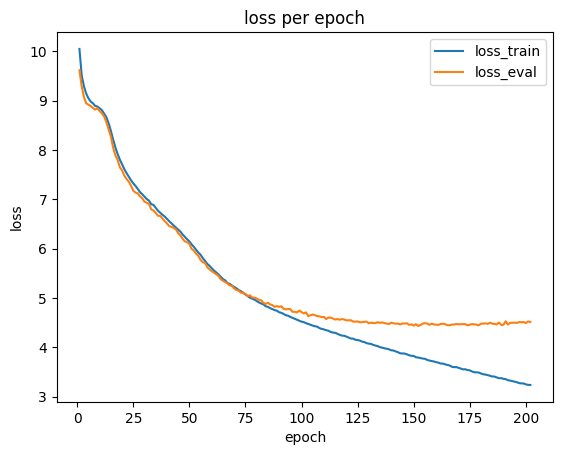

In [30]:
plt.plot(np.arange(1,len(loss_train)+1),loss_train,)
plt.plot(np.arange(1,len(loss_eval)+1),loss_eval,)
plt.legend(['loss_train','loss_eval'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss per epoch')
# plt.show()
plt.savefig('loss_per_epoch.png')

In [31]:
class EvaluationMetrics:
  def __init__(self,):
    pass
    #crossentropy is the loss of model wrt input
  def perplexity(self, crossentropy):
    return np.exp(crossentropy)

In [32]:
# an instance of class EvaluationMetrics
evaluation_metrics = EvaluationMetrics()

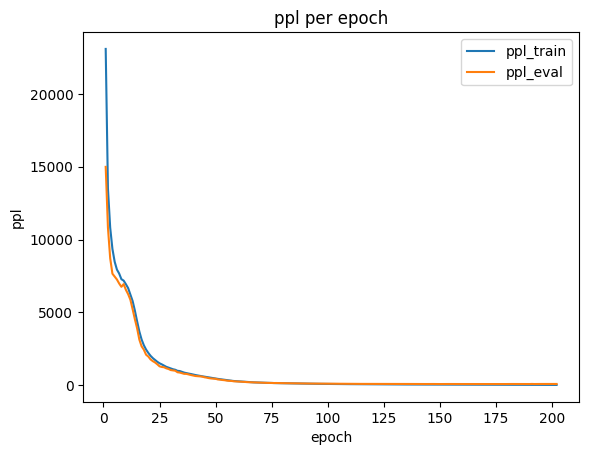

In [33]:
plt.plot(np.arange(1,len(loss_train)+1),evaluation_metrics.perplexity(loss_train))
plt.plot(np.arange(1,len(loss_eval)+1),evaluation_metrics.perplexity(loss_eval))
plt.legend(['ppl_train','ppl_eval'])
plt.xlabel('epoch')
plt.ylabel('ppl')
plt.title('ppl per epoch')
plt.show()

test

Epoch,Training Loss,Validation Loss
202,3.239400,4.500084


my logs: {'eval_loss': nan, 'eval_runtime': 0.0451, 'eval_samples_per_second': 22.197, 'eval_steps_per_second': 22.197, 'epoch': 202.0}


/usr/local/lib/python3.11/dist-packages/transformers/trainer_callback.py:739: RuntimeWarning: invalid value encountered in less
  operator(metric_value, state.best_metric)


nan
my logs: {'eval_loss': 3.8068325519561768, 'eval_runtime': 0.0611, 'eval_samples_per_second': 16.377, 'eval_steps_per_second': 16.377, 'epoch': 202.0}
3.8068325519561768
my logs: {'eval_loss': 4.136634349822998, 'eval_runtime': 0.0163, 'eval_samples_per_second': 61.493, 'eval_steps_per_second': 61.493, 'epoch': 202.0}
4.136634349822998
my logs: {'eval_loss': 3.9748857021331787, 'eval_runtime': 0.0151, 'eval_samples_per_second': 66.156, 'eval_steps_per_second': 66.156, 'epoch': 202.0}
3.9748857021331787
my logs: {'eval_loss': 5.579554557800293, 'eval_runtime': 0.0147, 'eval_samples_per_second': 67.965, 'eval_steps_per_second': 67.965, 'epoch': 202.0}
5.579554557800293
my logs: {'eval_loss': 5.290093421936035, 'eval_runtime': 0.0143, 'eval_samples_per_second': 70.158, 'eval_steps_per_second': 70.158, 'epoch': 202.0}
5.290093421936035
my logs: {'eval_loss': 3.7354133129119873, 'eval_runtime': 0.0152, 'eval_samples_per_second': 65.815, 'eval_steps_per_second': 65.815, 'epoch': 202.0}
3

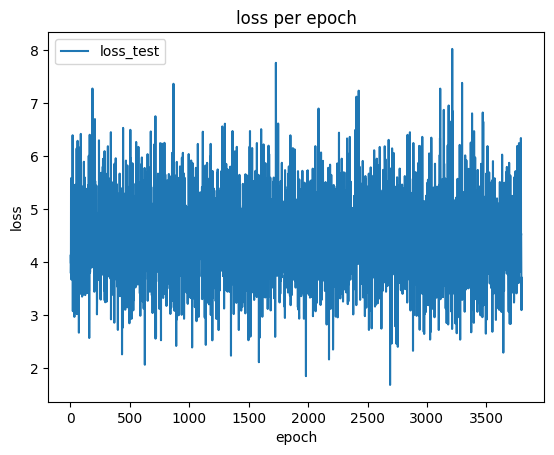

In [34]:
# copy loss_eval because when we call trainer.evaluate() on_log append loss of test to list of loss_eval so we have loss of eval loss on first part of the list and loss of test at the end part of the list.
# to not confront to this problem first we clear the content of loss_eval and after we use it for test set, we bring back the original value of loss_eval.
import copy
loss_eval_temp = copy.deepcopy(loss_eval)
loss_eval = []

loss_test = []
for i in range(len(test_dataset)): #check
  # print(sample)
  o = trainer.evaluate(eval_dataset=test_dataset[i:i+1],)
  print(o['eval_loss'])
  loss_test.append(o['eval_loss'])

loss_eval = copy.deepcopy(loss_eval_temp)

plt.plot(np.arange(1,len(loss_test)+1),loss_test)
plt.legend(['loss_test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss per epoch')
# plt.show()
plt.savefig('test_loss_per_epoch.png')


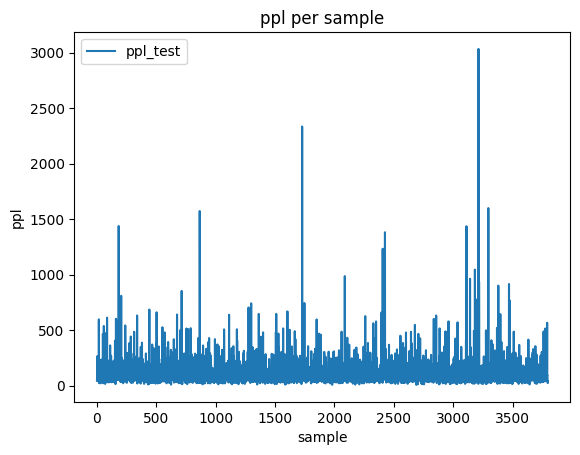

In [35]:
plt.plot(np.arange(1,len(loss_test)+1),evaluation_metrics.perplexity(loss_test))
plt.legend(['ppl_test'])
plt.xlabel('sample')
plt.ylabel('ppl')
plt.title('ppl per sample')
# plt.show()
plt.savefig('ppl_per_sample.png')

In [36]:
loss_eval_temp = copy.deepcopy(loss_eval)
loss_eval = []
# calculating perplexity of model using  test set. in eval_dataset you can use train, dev or test set
print('PPL:',evaluation_metrics.perplexity(trainer.evaluate(eval_dataset=test_dataset,)['eval_loss']))

loss_eval = copy.deepcopy(loss_eval_temp)

my logs: {'eval_loss': 4.500083923339844, 'eval_runtime': 14.0949, 'eval_samples_per_second': 269.389, 'eval_steps_per_second': 4.257, 'epoch': 202.0}
PPL: 90.02468615583362


# 2-7 Saving model

In [37]:
address = 'model'
trainer.save_model(address)

# Saving model checkpoint to ./HeartBert/mlm_model
# Configuration saved in ./HeartBert/mlm_model/config.json
# Model weights saved in ./HeartBert/mlm_model/pytorch_model.bin

# 3- Test



Aside from looking at the training and eval losses going down, the easiest way to check whether our language model is learning anything interesting is via the `FillMaskPipeline`.

Pipelines are simple wrappers around tokenizers and models, and the 'fill-mask' one will let you input a sequence containing a masked token (here, `<mask>`) and return a list of the most probable filled sequences, with their probabilities.



In [38]:
# from transformers import pipeline

# fill_mask = pipeline(
#     "fill-mask",
#     model= address,
#     tokenizer= address
# )